### This notebook aims to create an Excel file that tracks usage of reactions in the new model
With rows being all reactions in the model, and columns being whether a reaction is used in different conditions (T/F), and one column indicating new reactions
- [ ] basal condition
- [ ] rich condition
- [ ] acetate condition
- [ ] anaerobic (remove oxygen) condition
- [ ] remove oxygen and add nitrate exchange

May have to rerun all conditions if we modify the homeostatic objective function. 

In [1]:
import numpy as np
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

In [2]:
# load basal new model
time = '400'
date = '2025-01-30'
experiment = 'NEW_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_basal = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_basal = dill.load(f)
f.close()

# load rich new model
time = '400'
date = '2025-03-07'
experiment = 'NEW'
condition = 'with_aa'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_rich = output['listeners']['fba_results']
f = open(folder + 'agent_steps.pkl', 'rb')
agent_rich = dill.load(f)
f.close()

# load acetate new model
time = '400'
date = '2025-02-26'
experiment = 'NEW'
condition = 'acetate'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_acetate = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_acetate = dill.load(f)
f.close()

# get commonly stored variables
metabolism_basal = agent_basal['ecoli-metabolism-redux-classic']
metabolism_rich = agent_rich['ecoli-metabolism-redux-classic']
metabolism_acetate = agent_acetate['ecoli-metabolism-redux-classic']

stoichiometry = metabolism_basal.stoichiometry
reaction_names = metabolism_basal.reaction_names
kinetic_reaction_ids = metabolism_basal.kinetic_constraint_reactions
fba_new_reaction_ids = metabolism_basal.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism_basal.parameters['fba_reaction_ids_to_base_reaction_ids']
binary_kinetic_idx = metabolism_basal.binary_kinetic_idx
metabolites = metabolism_basal.metabolite_names

In [11]:
# create a dataframe to track reactions
conditions = ['basal', 'acetate', 'rich', 'anaerobic_basal', 'anaerobic_acetate', 'anaerobic_rich']
df_reaction_track = pd.DataFrame(index=reaction_names, columns=conditions, data=False)
df_reaction_flux  = pd.DataFrame(index=reaction_names, columns=conditions, data=False)

flux_basal = pd.DataFrame(fba_basal["estimated_fluxes"], columns= reaction_names).mean(axis=0)
flux_acetate = pd.DataFrame(fba_acetate["estimated_fluxes"], columns= reaction_names).mean(axis=0)
flux_rich = pd.DataFrame(fba_rich["estimated_fluxes"], columns= reaction_names).mean(axis=0)

In [12]:
df_reaction_track.loc[flux_basal[flux_basal != 0].index, 'basal'] = True
df_reaction_track.loc[flux_acetate[flux_acetate != 0].index, 'acetate'] = True
df_reaction_track.loc[flux_rich[flux_rich != 0].index, 'rich'] = True
df_reaction_flux.basal = flux_basal
df_reaction_flux.acetate = flux_acetate
df_reaction_flux.rich = flux_rich

In [13]:
df_reaction_track

,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,False,False,False,False,False,False
1.1.1.127-RXN,False,False,False,False,False,False
1.1.1.127-RXN (reverse),False,False,False,False,False,False
1.1.1.215-RXN (reverse),False,False,False,False,False,False
1.1.1.251-RXN,False,False,False,False,False,False
...,...,...,...,...,...,...
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,False,False,False,False,False,False
YIAE1-RXN (reverse),False,False,False,False,False,False
glycogen-monomer-extension,True,False,True,False,False,False
DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.DEPHOSICITDEHASE-RXN,False,False,False,False,False,False


### Simulate anaerobic condition

In [6]:
FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]
def test_condition(metabolism, fba, uptake_addition = set([]), uptake_remove=set([]), objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.0000001}):
    uptake = metabolism.allowed_exchange_uptake
    uptake = set(uptake)

    uptake = uptake | uptake_addition
    uptake = uptake - uptake_remove
    
    model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)
    
    homeostatic_count = pd.DataFrame(fba["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).loc[24, :]
    homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
    maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
    kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]

    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count * metabolism.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            binary_kinetic_idx=binary_kinetic_idx,
            force_flow_idx=None,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP)
    return solution.velocities, solution.exchanges

In [57]:
# simulate anaerobic condition
anaerobic_basal_velocities, anaerobic_basal_exchanges = test_condition(metabolism_basal, fba_basal, uptake_remove={'OXYGEN-MOLECULE[p]'})
anaerobic_acetate_velocities, anaerobic_acetate_exchanges = test_condition(metabolism_acetate, fba_acetate, uptake_remove={'OXYGEN-MOLECULE[p]'})
no_ammonia_velocities, no_ammonia_exchanges = test_condition(metabolism_basal, fba_basal, uptake_remove={'AMMONIUM[p]'})
anaerobic_nitric_oxide_velocities, anaerobic_nitric_oxide_exchanges = test_condition(metabolism_basal, fba_basal, uptake_remove={'OXYGEN-MOLECULE[p]'}, uptake_addition={'NITRATE[p]'})
# anaerobic_rich_velocities, anaerobic_rich_exchanges = test_condition(metabolism_rich, fba_rich, uptake_remove={'OXYGEN-MOLECULE[p]'})

df_reaction_flux.anaerobic_basal = anaerobic_basal_velocities
df_reaction_flux.anaerobic_acetate = anaerobic_acetate_velocities
df_reaction_track.loc[df_reaction_flux.anaerobic_basal!=0, 'anaerobic_basal'] = True
df_reaction_track.loc[df_reaction_flux.anaerobic_acetate!=0, 'anaerobic_acetate'] = True

anaerobic rich doesn't solve

Text(0.5, 1.0, 'Top 10 exchanges for anaerobic acetate')

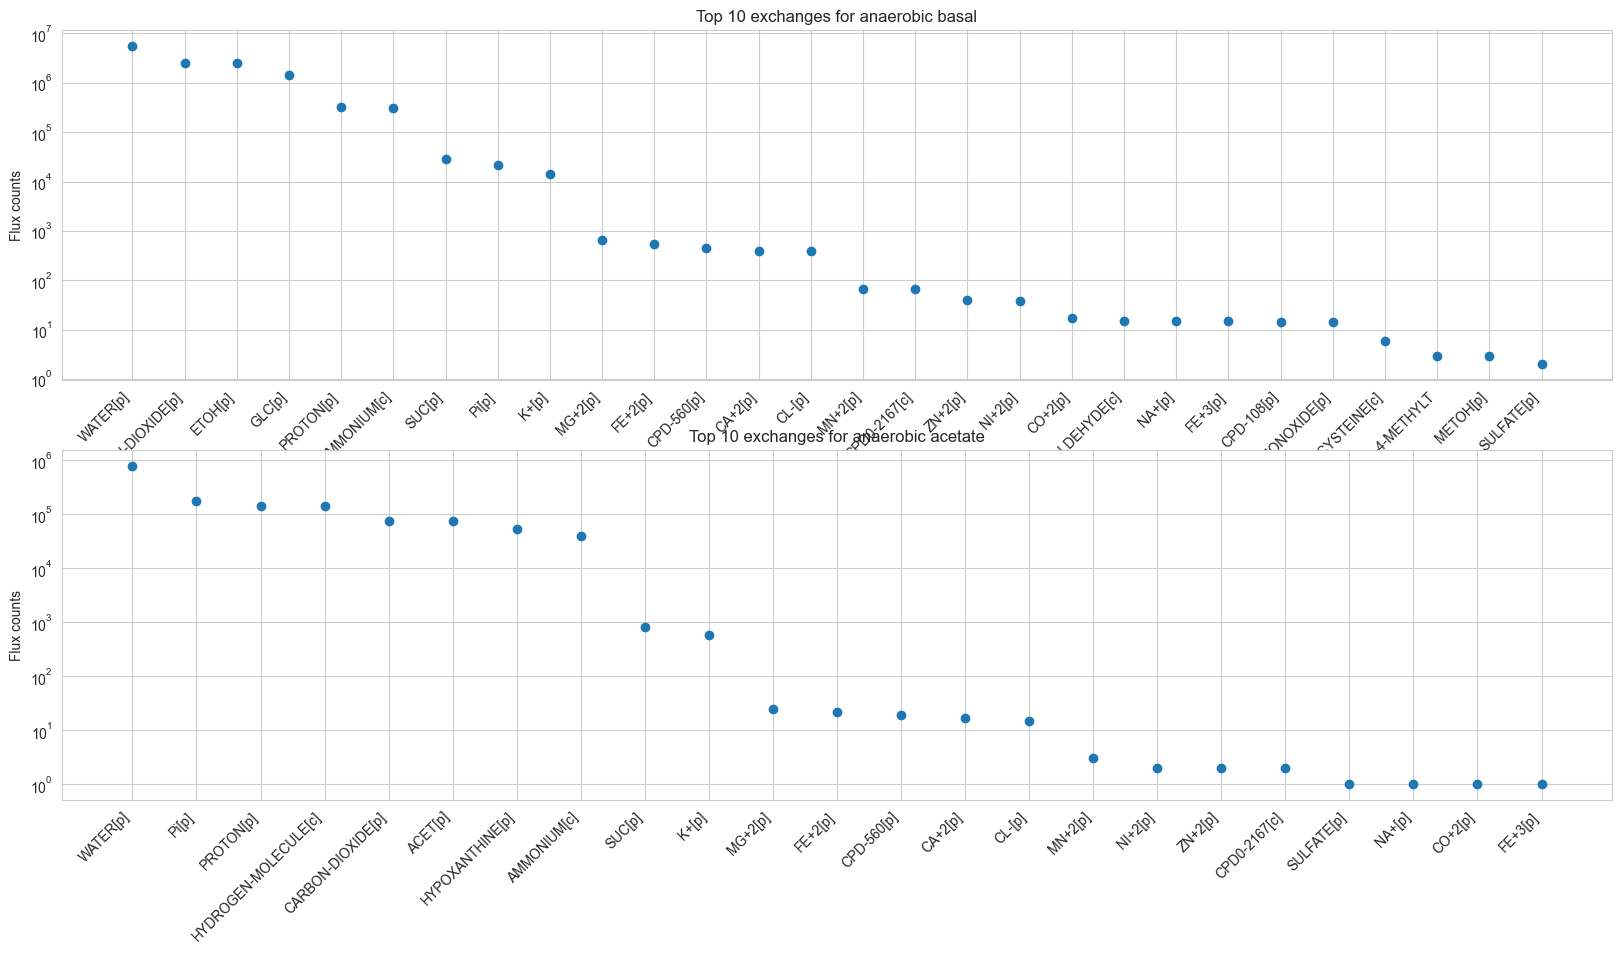

In [8]:
%matplotlib inline
# plot anaerobic basal and acetate exchanges
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
cur_exchanges = pd.Series(anaerobic_basal_exchanges, index=metabolism_basal.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])
ax[0].plot(cur_exchanges.head(nonzero), 'o')
ax[0].set_xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
ax[0].set_yscale('log')
ax[0].set_ylabel('Flux counts')
ax[0].set_title('Top 10 exchanges for anaerobic basal')

cur_exchanges = pd.Series(anaerobic_acetate_exchanges, index=metabolism_acetate.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])
ax[1].plot(cur_exchanges.head(nonzero), 'o')
ax[1].set_xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
ax[1].set_yscale('log')
ax[1].set_ylabel('Flux counts')
ax[1].set_title('Top 10 exchanges for anaerobic acetate')
# plt.show()


In [28]:
df_reaction_track['is_used'] = np.any(df_reaction_track[conditions], axis=1)
df_reaction_track['is_new'] = False
df_reaction_track['is_kinetic'] = False
df_reaction_flux['is_new'] = False
df_reaction_flux['is_kinetic'] = False

df_reaction_track.loc[fba_new_reaction_ids, 'is_new'] = True
df_reaction_track.loc[kinetic_reaction_ids, 'is_kinetic'] = True
df_reaction_flux.loc[fba_new_reaction_ids, 'is_new'] = True
df_reaction_flux.loc[kinetic_reaction_ids, 'is_kinetic'] = True

In [32]:
df_reaction_track.loc[df_reaction_track.is_new == True,:]

,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,is_used,is_new,is_kinetic
1.1.1.271-RXN (reverse),False,False,False,False,False,False,False,True,False
1.11.1.15-RXN,False,False,False,False,False,False,False,True,False
1.13.11.16-RXN,False,False,False,False,False,False,False,True,True
1.97.1.4-A-RXN,False,False,False,False,False,False,False,True,False
1PFRUCTPHOSN-RXN,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
TREHALA-RXN[CCO-PERI-BAC]-TREHALOSE/WATER//GLC/ALPHA-GLUCOSE.49.,False,False,False,False,False,False,False,True,True
UDPMANACATRANS-RXN,False,False,False,False,False,False,False,True,False
UDPMANNACADEHYDROG-RXN,False,False,False,False,False,False,False,True,False
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCI-PERI-BAC-GN]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.68.,False,False,False,False,False,False,False,True,False


In [58]:
anaerobic_basal_velocities_df = pd.DataFrame(anaerobic_basal_velocities, index=reaction_names, columns=['anaerobic_basal'])
anaerobic_acetate_velocities_df = pd.DataFrame(anaerobic_acetate_velocities, index=reaction_names, columns=['anaerobic_acetate'])
no_ammonia_velocities_df = pd.DataFrame(no_ammonia_velocities, index=reaction_names, columns=['no_ammonia'])
anaerobic_nitric_oxide_velocities_df = pd.DataFrame(anaerobic_nitric_oxide_velocities, index=reaction_names, columns=['anaerobic_nitric_oxide'])

In [59]:
%store -r rxn_nitrate
anaerobic_nitric_oxide_velocities_df.loc[rxn_nitrate,:]

,anaerobic_nitric_oxide
NITRATE-REDUCTASE-CYTOCHROME-RXN-Reduced-NapC-proteins/NITRATE/PROTON//Oxidized-NapC-proteins/NITRITE/WATER.75.,-0.000000
R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.,-0.000000
R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.,-0.000000
RXN-13854 (reverse),-0.000000
RXN-23276,-0.000000
RXN-23850 (reverse),0.000000
RXN0-2721,0.000000
RXN0-3501-NITRATE/REDUCED-MENAQUINONE/PROTON//NITRITE/CPD-9728/WATER/PROTON.66.,367226.538462
RXN0-6369-NITRATE/CPD-9956//NITRITE/UBIQUINONE-8/WATER.45.,-0.000000
RXN0-7124-NITRATE/CPD-9956/PROTON//NITRITE/UBIQUINONE-8/PROTON/WATER.59.,50090.000000


In [41]:
S = metabolism_basal.stoichiometry.copy()


### instead of tracking reactions, track gene usage. 
i.e. map reactions to enzyme, then enzyme to genes.

In [101]:
NOTEBOOK_DIR = f'notebooks/Heena notebooks/Metabolism_New Genes'
def string_to_list(s):
    try:
        return np.array(ast.literal_eval(s))  # Safely convert string to list
    except (ValueError, SyntaxError):
        return np.array(s)  # Return as-is if conversion fails (e.g., NaN values)

def get_keys(dict, value):
    return [key for key in dict if dict[key] == value]

metabolic_gene_annotation = pd.read_csv(os.path.join(NOTEBOOK_DIR, "new_metabolic_gene_annotation.csv"), converters={'Reactions': string_to_list})

In [99]:
reaction_to_enzymes = metabolism_basal.parameters["reaction_catalysts"]
new_reaction_enzymes = {rxn:reaction_to_enzymes[rxn] for rxn in fba_new_reaction_ids}
genes_to_enzymes = metabolic_gene_annotation.set_index('Gene name')['Enzyme encoded'].to_dict()

df_gene_usage = metabolic_gene_annotation.loc[:,['Enzyme encoded', 'Reactions']]
df_gene_usage.set_index(metabolic_gene_annotation['Gene name'], inplace=True)

In [109]:
# take basal condition as an example
basal_new_reaction_usage = df_reaction_track.loc[fba_new_reaction_ids,'basal']
df_gene_usage['basal'] = 0
for rxn in fba_new_reaction_ids:
    is_used = basal_new_reaction_usage.loc[rxn]
    if is_used:
        enzymes = new_reaction_enzymes[rxn]
        for enz in enzymes:
            genes = get_keys(genes_to_enzymes, enz)
            for gene in genes:
                df_gene_usage.loc[gene, 'basal'] += 1

In [96]:
df_reaction_track.loc[fba_new_reaction_ids,'basal']

1.1.1.271-RXN (reverse)                                                                    False
1.11.1.15-RXN                                                                              False
1.13.11.16-RXN                                                                             False
1.97.1.4-A-RXN                                                                             False
1PFRUCTPHOSN-RXN                                                                           False
                                                                                           ...  
RXN0-5462[CCO-CYTOSOL]-GTP/WATER//GDP/Pi/PROTON.38.__G7841-MONOMER                         False
RXN0-5462[CCO-CYTOSOL]-GTP/WATER//GDP/Pi/PROTON.38.__EG12104-MONOMER                       False
RXN0-5462[CCO-CYTOSOL]-GTP/WATER//GDP/Pi/PROTON.38.__EG10021-MONOMER                       False
RXN0-6732__CPLX0-7958                                                                      False
THIOSULFATE-SULFURTRANSFERASE-

In [92]:
for enz in reaction_to_enzymes['HOMOSERKIN-RXN']:
    print(enz)

HOMOSERKIN-CPLX[c]


In [91]:
fba_new_reaction_ids

['1.1.1.271-RXN (reverse)',
 '1.11.1.15-RXN',
 '1.13.11.16-RXN',
 '1.97.1.4-A-RXN',
 '1PFRUCTPHOSN-RXN',
 '2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.',
 '2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.',
 '2.1.1.79-RXN-CPD-18367/S-ADENOSYLMETHIONINE//CPD-18371/ADENOSYL-HOMO-CYS/PROTON.67.',
 '2.1.1.79-RXN-CPD-18369/S-ADENOSYLMETHIONINE//CPD-18372/ADENOSYL-HOMO-CYS/PROTON.67.',
 '2.1.1.79-RXN-CPD-18392/S-ADENOSYLMETHIONINE//CPD-18405/ADENOSYL-HOMO-CYS/PROTON.67.',
 '2.1.1.79-RXN-CPD-18403/S-ADENOSYLMETHIONINE//CPD-18404/ADENOSYL-HOMO-CYS/PROTON.67.',
 '2.7.3.9-RXN',
 '2.7.7.61-RXN',
 '2.7.8.25-RXN',
 '2.7.9.3-RXN',
 '2.9.1.1-RXN',
 '3.1.3.68-RXN[CCO-CYTOSOL]-2-DEOXY-D-GLUCOSE-6-PHOSPHATE/WATER//2-DEOXY-D-GLUCOSE/Pi.71.',
 '3.4.17.8-RXN',
 '4.3.1.15-RXN',
 '6-PHOSPHO-BETA-GLUCOSIDASE-RXN',
 '6-PHOSPHO-BETA-GLUCOSIDASE-RXN-CPD-15978/WATER//ALPHA-GLC-6-P/ALPHA-GLUCOSE.45.',
 '6-PHOSPHO-BETA-GLUCOSIDASE-RXN-CPD-159

In [100]:
new_reaction_enzymes

{'1.1.1.271-RXN (reverse)': ['CPLX0-3881[c]'],
 '1.11.1.15-RXN': ['CPLX0-7747[c]', 'CPLX0-8157[c]', 'EG10108-MONOMER[c]'],
 '1.13.11.16-RXN': ['DHPDIOXYGEN-CPLX[i]'],
 '1.97.1.4-A-RXN': ['PFLACTENZ-MONOMER[c]'],
 '1PFRUCTPHOSN-RXN': ['1-PFK[c]'],
 '2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.': ['CFA-CPLX[c]'],
 '2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.': ['CFA-CPLX[c]'],
 '2.1.1.79-RXN-CPD-18367/S-ADENOSYLMETHIONINE//CPD-18371/ADENOSYL-HOMO-CYS/PROTON.67.': ['CFA-CPLX[c]'],
 '2.1.1.79-RXN-CPD-18369/S-ADENOSYLMETHIONINE//CPD-18372/ADENOSYL-HOMO-CYS/PROTON.67.': ['CFA-CPLX[c]'],
 '2.1.1.79-RXN-CPD-18392/S-ADENOSYLMETHIONINE//CPD-18405/ADENOSYL-HOMO-CYS/PROTON.67.': ['CFA-CPLX[c]'],
 '2.1.1.79-RXN-CPD-18403/S-ADENOSYLMETHIONINE//CPD-18404/ADENOSYL-HOMO-CYS/PROTON.67.': ['CFA-CPLX[c]'],
 '2.7.3.9-RXN': ['CPLX0-7938[c]'],
 '2.7.7.61-RXN': ['G6340-MONOMER[c]'],
 '2.7.8.25-RXN': ['G6339-MONOMER[c]'],
 '2.7.9.3-

In [102]:
metabolic_gene_annotation.head()

,Gene ID (EcoCyc),Gene locus ID,Gene name,Enzyme encoded,Pathways,Pathways parent,Protein products,MultiFuntional ID,MultiFuntional name,Reactions,Description by Cyrus
0,EG10022,b4015,aceA,ISOCIT-LYASE,GLYOXYLATE-BYPASS,Energy-Metabolism,ISOCIT-LYASE-MONOMER,BC-1.7.2,['metabolism -> central intermediary metabolism -> glyoxylate bypass'],ISOCIT-CLEAV-RXN,acetate transport + metabolism
1,EG10023,b4014,aceB,MALATE-SYNTHASE,GLYOXYLATE-BYPASS,Energy-Metabolism,MALATE-SYNTHASE,BC-1.7.2,['metabolism -> central intermediary metabolism -> glyoxylate bypass'],MALSYN-RXN,acetate transport + metabolism
2,EG11942,b4067,actP,CPLX0-7955,NaN,NaN,YJCG-MONOMER,"['BC-4.2.A', 'BC-6.1']","['transport -> Electrochemical potential driven transporters -> Porters (Uni-, Sym- and Antiporters)', 'cell structure -> membrane']","[RXN0-1981, RXN0-5111, TRANS-RXN0-576]",acetate transport + metabolism
3,EG11724,b3714,adeP,EG11724-MONOMER,NaN,NaN,EG11724-MONOMER,BC-4.2.A,"['transport -> Electrochemical potential driven transporters -> Porters (Uni-, Sym- and Antiporters)']",TRANS-RXN0-447,adenine transport
4,EG12462,b4115,adiC,CPLX0-7535,NaN,NaN,YJDE-MONOMER,"['BC-4.2.A', 'BC-6.1']","['transport -> Electrochemical potential driven transporters -> Porters (Uni-, Sym- and Antiporters)', 'cell structure -> membrane']",RXN0-2162,"transport, acid resistance"


In [105]:
df_gene_usage = metabolic_gene_annotation.loc[:,['Enzyme encoded', 'Reactions']]
df_gene_usage.set_index(metabolic_gene_annotation['Gene name'], inplace=True)

In [110]:
df_gene_usage

,Enzyme encoded,Reactions,basal
Gene name,,,
aceA,ISOCIT-LYASE,ISOCIT-CLEAV-RXN,0
aceB,MALATE-SYNTHASE,MALSYN-RXN,0
actP,CPLX0-7955,"[RXN0-1981, RXN0-5111, TRANS-RXN0-576]",0
adeP,EG11724-MONOMER,TRANS-RXN0-447,0
adiC,CPLX0-7535,RXN0-2162,0
...,...,...,...
ynfH,CPLX0-1601,RXN-24479,0
ypdF,CPLX0-8290,RXN0-5052,0
yqaB,G7408-MONOMER,RXN0-5186,0


In [111]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [122]:
req_func = f"https://websvc.biocyc.org/apixml?fn=enzymes-of-gene&id=ECOLI:EG11658&detail=full"
# response_func = s.get(req_func)
# xmltodict.parse(response_func.content)['ptools-xml']['Gene']

In [123]:
response_func = s.get(req_func)
response_func.status_code

200

In [125]:
xmltodict.parse(response_func.content)['ptools-xml'].keys()

dict_keys(['@ptools-version', '@xml:base', 'metadata', 'Protein'])